In [29]:
#pip install pymongo
#pip install gensim

In [31]:
# Import necessary libs
import pandas as pd
import re
import numpy as np
import time
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Spacy
import spacy

# Plotting
import matplotlib.pyplot as plot

# Mongo DB
from pymongo import MongoClient

In [32]:
# import data from MongoDB
DBClient = MongoClient()
yelp_data = DBClient.yelp

In [33]:
# Select business having atleast 50 reviews
min_review_count = 50

# businesses to Analyse
businesses_to_analyse = 'Restaurants'

In [28]:
# Get all restaurant businesses
Restaurant_business = pd.DataFrame(yelp_data.business.find({"categories":{"$regex" :".*"+businesses_to_analyse+".*"}, "review_count":{"$gte":min_review_count} },  {'business_id':1, 'name':1, 'city':1, 'state':1, 'stars':1, 'review_count':1, 'categories':1, '_id': 0}))

In [29]:
# Get all reviews
All_reviews = pd.DataFrame(yelp_data.review.find({},{'review_id':1, 'user_id':1, 'business_id':1, 'stars':1, 'useful':1, 'text':1, 'date':1, '_id': 0}))

In [7]:
# Find all restaurant reviews
#Restaurant_reviews = All_reviews[All_reviews.business_id.isin(Restaurant_business.business_id.values)]
Restaurant_reviews = pd.merge(Restaurant_business,All_reviews, on='business_id').rename(columns={'stars_x':'business_stars', 'stars_y':'review_stars'})

In [8]:
# Sample 5 Restaurant
Restaurant_business.head(5)

,business_id,name,city,state,stars,review_count,categories
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported..."
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,Charlotte,NC,4.0,170,"Sushi Bars, Restaurants, Japanese"
2,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,Las Vegas,NV,4.5,184,"Mexican, Restaurants, Patisserie/Cake Shop, Fo..."
3,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,Toronto,ON,3.0,57,"Juice Bars & Smoothies, Food, Restaurants, Fas..."
4,dQj5DLZjeDK3KFysh1SYOQ,Apteka,Pittsburgh,PA,4.5,242,"Nightlife, Bars, Polish, Modern European, Rest..."


In [9]:
# Sample 5 Reviews
Restaurant_reviews.head(5)

,business_id,name,city,state,business_stars,review_count,categories,review_id,user_id,review_stars,useful,text,date
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",6W0MQHmasK0IsaoDo4bmkw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,3,My girlfriend and I went for dinner at Emerald...,2017-01-27 21:54:30
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",BeeBfUxvzD4qNX4HxrgA5g,A0kENtCCoVT3m7T35zb2Vg,3.0,0,We've always been there on a Sunday so we were...,2013-06-24 23:11:30
2,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",A1D2kUnZ0HTroFreAheNSg,SuOLY03LW5ZcnynKhbTydA,3.0,0,"***No automatic doors, not baby friendly!*** I...",2016-01-04 12:59:22
3,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",2pf45Stf-pNew-xgTababQ,lymyUak6KNcNKoDbK87MiQ,1.0,1,"Horrible service,\nI went there tonight with m...",2014-05-09 02:38:43
4,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,Mississauga,ON,2.5,128,"Specialty Food, Restaurants, Dim Sum, Imported...",RHhlmL07evgAdPaXQV8Omg,6vU0I5XgCv9OQHZ76rV6qw,4.0,2,One of the gauges of a good Chinese restaurant...,2011-03-21 14:39:55


In [10]:
# Write selected Restaurants to file
Restaurant_reviews.to_csv('processed_data/restaurant_reviews.csv')

In [11]:
# Write selected Restaurant-reviews to file
Restaurant_business.to_csv('processed_data/restaurants.csv')

Text(0.5, 1.0, 'Number of Reviews Per Rating of Restaurants')

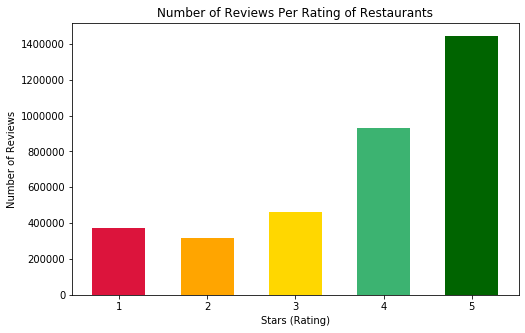

In [12]:
# plot how many reviews we have of each star
star_x = Restaurant_reviews.review_stars.value_counts().index
star_y = Restaurant_reviews.review_stars.value_counts().values

plot.figure(figsize=(8,5))
# colors are in the order 5, 4, 3, 1, 2
bar_colors = ['darkgreen', 'mediumseagreen', 'gold', 'crimson', 'orange']
plot.bar(star_x, star_y, color=bar_colors, width=.6)
plot.xlabel('Stars (Rating)')
plot.ylabel('Number of Reviews')
plot.title(f'Number of Reviews Per Rating of {businesses_to_analyse}')

In [13]:
Restaurant_business.groupby('state').count()

,business_id,name,city,stars,review_count,categories
state,,,,,,
AB,298,298,298,298,298,298
AZ,5216,5216,5216,5216,5216,5216
IL,157,157,157,157,157,157
NC,1405,1405,1405,1405,1405,1405
NV,3989,3989,3989,3989,3989,3989
OH,1262,1262,1262,1262,1262,1262
ON,3092,3092,3092,3092,3092,3092
PA,1063,1063,1063,1063,1063,1063
QC,591,591,591,591,591,591


In [14]:
restaurants_per_state = Restaurant_business.groupby('state').count()[['business_id']].rename(columns={'state': 'State', 'business_id': 'Restaurants'})

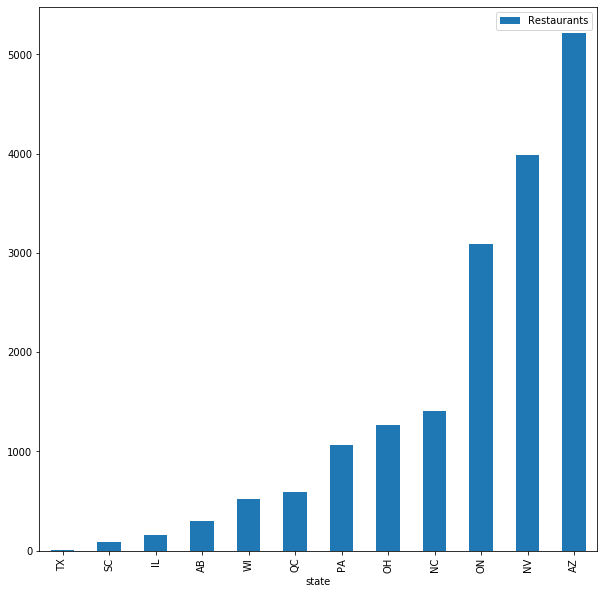

In [16]:
restaurants_per_state.sort_values(by='Restaurants').plot.bar(figsize=(10,10))

In [17]:
Restaurant_AZ = pd.DataFrame(yelp_data.business.find({"categories":{"$regex" :".*"+businesses_to_analyse+".*"}, "review_count":{"$gte":min_review_count}, "state":"AZ" },  {'business_id':1, 'name':1, 'city':1, 'state':1, 'stars':1, 'review_count':1, 'categories':1, '_id': 0}))

In [18]:
Restaurant_AZ_reviews = pd.merge(Restaurant_AZ,All_reviews, on='business_id').rename(columns={'stars_x':'business_stars', 'stars_y':'review_stars'})

In [19]:
Restaurant_AZ_reviews.to_csv('processed_data/restaurant_az_reviews.csv')

In [20]:
Restaurant_AZ.to_csv('processed_data/restaurants_az.csv')

In [21]:
Restaurant_AZ_reviews.shape

(1075198, 13)

Text(0.5, 1.0, 'Number of Reviews Per Rating of Restaurants')

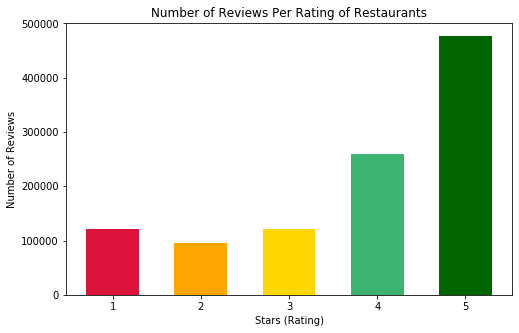

In [22]:
# plot how many reviews we have of each star
star_x = Restaurant_AZ_reviews.review_stars.value_counts().index
star_y = Restaurant_AZ_reviews.review_stars.value_counts().values

plot.figure(figsize=(8,5))
# colors are in the order 5, 4, 3, 1, 2
bar_colors = ['darkgreen', 'mediumseagreen', 'gold', 'crimson', 'orange']
plot.bar(star_x, star_y, color=bar_colors, width=.6)
plot.xlabel('Stars (Rating)')
plot.ylabel('Number of Reviews')
plot.title(f'Number of Reviews Per Rating of {businesses_to_analyse}')

In [87]:
# for now we restrich Restaurants to this number to develop the code
sample_restaurants_to_load = 10

# Only Arizona Businesses, Change if needed
restaurant_file='processed_data/restaurants_az.csv'
reviews_file   ='processed_data/restaurant_az_reviews.csv'

# Number of topic
NUM_TOPICS = 10

In [88]:
%%time
# SPACY
# This is the large Spacy English Library
nlp = spacy.load('en_core_web_lg')

Wall time: 11 s


In [89]:
# Stopwords for topic mining
stopwords = [line.rstrip('\n') for line in open('config/stopwords.txt', 'r')]

In [90]:
# The words that appear in names of the Restaurants
# Restaurants name may appear multiple time in review, increasing its word frequenty
# For topic mining per restaurant, it is not useful and should be removed
# However words such as 'chicken' when come in restaurant name should be retained
stopnames = [line.rstrip('\n').lower() for line in open('config/names.txt', 'r')]

In [91]:
%%time
# Read Businesses
all_restaurants = pd.read_csv(restaurant_file).drop(labels='Unnamed: 0', axis=1).head(sample_restaurants_to_load)

Wall time: 22 ms


In [92]:
%%time
# Read all reviews
all_reviews = pd.read_csv(reviews_file).drop(labels='Unnamed: 0', axis=1)

Wall time: 11.2 s


In [93]:
%%time
# Retain reviews of selected Businesses
all_reviews = all_reviews[all_reviews.business_id.isin(all_restaurants.business_id)]

Wall time: 363 ms


In [94]:
%%time
# Top 5 Reviews
all_reviews.head()

Wall time: 0 ns


,business_id,name,city,state,business_stars,review_count,categories,review_id,user_id,review_stars,useful,text,date
0,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",QgV9RPyPUC3cAse1Wxqoow,P3cMpkppvBuVpPD8LBTbBQ,4.0,2,Enjoyed Nee House immensely. No service issues...,2012-04-28 21:08:22
1,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",1ZTO6zFtVVxtXclHp4TvHQ,b1yLsCdv4ZL_d3INMCZzoA,3.0,0,I'm not sure how I rate this restaurant becaus...,2017-02-09 05:15:25
2,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",h17ep5S7O8_JMKovooWoVA,TaVuQWmXAhxy_LvIXBs9sg,5.0,0,The food from this place reminds me of home. I...,2016-08-12 21:38:55
3,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",FVJaiFuf67Dzamax-zq1UQ,aCY0jMl8Jsvx_HQL4D3tmw,4.0,2,Found this place by just driving down the road...,2011-08-24 22:35:28
4,44YFU284Z3KDEy25QyVoUw,Nee House Chinese Restaurant,Phoenix,AZ,3.5,269,"Chinese, Restaurants",zqzOcreb9KBTaESR6qbTSg,TPZbqNXMA2xMXLLd1zL_0A,4.0,2,We eat here on a regular basis. It's like tha...,2013-04-11 02:26:52


In [95]:
def tokenize_docs(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True re

In [96]:
# String List cleaning, removes spaces, new lines
def clean_string(data):
    data = [re.sub('\s+', ' '  , sent) for sent in data]
    data = [re.sub("n't", 'not', sent) for sent in data]
    data = [sent.lower()               for sent in data]
    data = list(tokenize_docs(data))
    data = [[tok for tok in sent if tok not in stopwords ] for sent in data]
    return data

In [106]:
def clean_name(name):
    name_toks = []
    
    # Nlp doc from Name
    name_doc = nlp(name)
    for token in name_doc:
        
        # Retain Proper nouns in Name
        if token.pos_ == 'PROPN' or token.like_num:
        
            # Lose stop words in Name
            if token.text.lower() not in stopnames:
            
                # All Restaurant name tokens to be remoed from reviews of this reataurant
                name_toks.append(token.text.lower())
    
    # Bigrams
    for i in range(len(name_toks)-1):
        name_toks.append(name_toks[i]+"_"+name_toks[i+1])
        
    return name_toks

In [107]:
def clean_doc(doc,name_toks):
    
    # Remove punctuation, symbols (#) and stopwords
    allowed_postags=['PROPN', 'NOUN', 'ADJ', 'VERB', 'ADV']
    
    #doc = [tok.text for tok in doc if (tok.text.lower() not in stopwords and tok.pos_ != "PUNCT" and tok.pos_ != "SYM")]
    toks = [tok.lemma_.lower().strip() for tok in doc 
                if (tok.text.lower().strip() not in stopwords 
                    and tok.text.lower() not in name_toks 
                    and tok.pos_ in allowed_postags)]
    return " ".join(toks)

In [108]:
def tokenize_docs(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True re

In [109]:
%%time
total = len(all_restaurants)
cleansed_text = []
for index, restaurant in all_restaurants.iterrows():
    #print(f'Cleaning reviews for restaurant: "{restaurant["name"]:<{40}}" [{index+1:>{5}}/{total:>{5}}]')
    if index % 100 == 0:
        print(f'Cleaning reviews [{index+1:>{5}}/{total:>{5}}]')
    
    # Convert to list
    data = all_reviews.query(' business_id == "'+restaurant['business_id']+'" ')['text']
    
    # Remove new lines, spaces, etc. Remove stopwords
    data = clean_string(data)
    
    # Build the bigram and trigram models
    bigram  = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod  = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    bigrams  = [bigram_mod[doc] for doc in data]
    trigrams = [trigram_mod[bigram_mod[doc]] for doc in data]
    
    data = [" ".join(trigram) for trigram in trigrams]
    
    # iterate list, clean sentences
    for parsed_review in nlp.pipe(iter(data), batch_size=1000, n_threads=8):
        cleansed_text.append(clean_doc(parsed_review,clean_name(restaurant["name"])))



Cleaning reviews [    1/   10]
Wall time: 48.4 s


In [110]:
all_reviews['cleansed_text'] = cleansed_text
all_reviews.to_csv('processed_data/cleaned_reviews.csv')
all_restaurants.to_csv('processed_data/cleaned_restaurants.csv')

In [ ]:
#END